## TEA PLANT DISEASE IDENTIFICATION

### IMPORT REQUIRED LIBRARIES

In [1]:
import tensorflow as tf
# from tensorflow.keras import layers, models
import keras
from keras import layers
from keras import models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import datetime
# from tensorflow.keras import layers, models, regularizers
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import pathlib

### CONSTANTS

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 50
DATA_DIR = r"C:\Users\ANISH BHUIN\OneDrive\Desktop\jbooks\teaLeafBD"
MODEL_PATH = "tea_leaf_disease_model.keras"

### LOAD DATASET

In [3]:
def load_dataset(data_dir):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        seed=123,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )
    return dataset

dataset = load_dataset(DATA_DIR)
class_names = dataset.class_names
n_classes = len(class_names)

print(f"Found {len(dataset)*BATCH_SIZE} images belonging to {n_classes} classes.")
print("Class names:", class_names)

Found 5276 files belonging to 7 classes.
Found 5280 images belonging to 7 classes.
Class names: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']


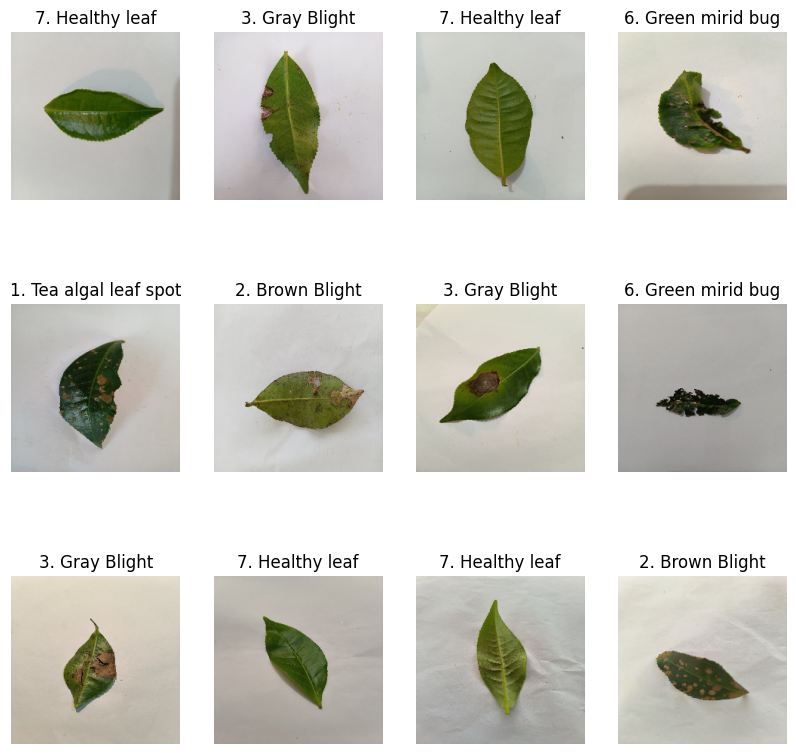

In [4]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### SPLIT,CATCH,SUFFLE AND PREFETCH THE DATA

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000, seed=42):
    assert (train_split + val_split + test_split) == 1.0, "Splits must add up to 1.0"
    
    # Calculate dataset size
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    if ds_size == tf.data.INFINITE_CARDINALITY:
        raise ValueError("Dataset has infinite cardinality; cannot split.")
    elif ds_size == tf.data.UNKNOWN_CARDINALITY:
        raise ValueError("Dataset size is unknown; cannot split. Consider using a dataset where cardinality can be determined.")
    
    # Shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_size, seed=seed, reshuffle_each_iteration=False)

    # Compute sizes
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    # Split the dataset
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds


In [6]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(f"Train: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Val: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test: {tf.data.experimental.cardinality(test_ds).numpy()}")


Train: 132
Val: 16
Test: 17


In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)      # No shuffle
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)     # No shuffle

### BUILDING THE MODEL

#### CREATING A LAYER FOR RESIZING AND NORMALIZATION

In [8]:
# from tensorflow.keras import layers
from keras import layers
from keras import models
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

### DATA AUGMENTATION

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),  # Increased rotation for leaf variations
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

In [10]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### MODEL ARCHITECTURE

In [40]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [41]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,719 (670.78 KB)

 Trainable params: 171,719 (670.78 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling The Model

### TRAIN THE MODEL

In [42]:
early_stop = EarlyStopping(
    monitor='val_loss',        # What to watch: 'val_loss' or 'val_accuracy'
    patience=5,                # Number of epochs to wait after no improvement
    restore_best_weights=True # Revert to best model weights
)

In [43]:
n_classes = 7

In [44]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [45]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 87s 639ms/step - accuracy: 0.2124 - loss: 1.8902 - val_accuracy: 0.3379 - val_loss: 1.8167
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 83s 627ms/step - accuracy: 0.3093 - loss: 1.7881 - val_accuracy: 0.3555 - val_loss: 1.7665
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 85s 645ms/step - accuracy: 0.3797 - loss: 1.6420 - val_accuracy: 0.4453 - val_loss: 1.4487
Epoch 4/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 83s 625ms/step - accuracy: 0.4837 - loss: 1.3945 - val_accuracy: 0.5391 - val_loss: 1.2021
Epoch 5/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 83s 624ms/step - accuracy: 0.5721 - loss: 1.2065 - val_accuracy: 0.6074 - val_loss: 1.0506
Epoch 6/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 84s 632ms/step - accuracy: 0.5976 - loss: 1.0905 - val_accuracy: 0.6660 - val_loss: 0.9400
Epoch 7/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 91s 690ms/step - accuracy: 0.6000 - loss: 1.0601 - val_accuracy: 0.6660 - val_loss: 0.8896
Epoch 8/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 84s 637ms/step - accuracy: 0.6215 - loss: 0

In [46]:
scores = model.evaluate(test_ds)

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.7532 - loss: 0.6154


In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

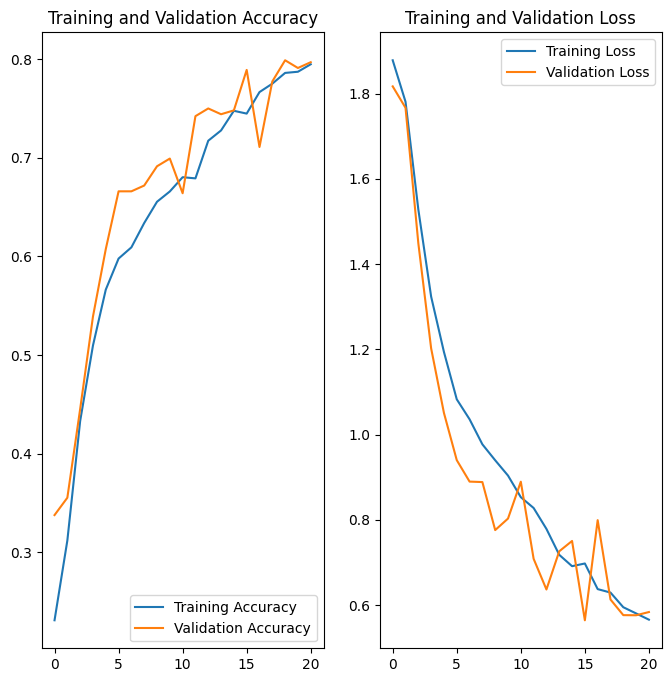

In [48]:
epochs_range = range(len(acc))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: 6. Green mirid bug
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
predicted label: 6. Green mirid bug


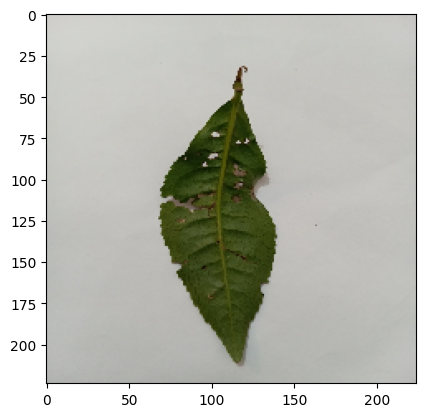

In [49]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [50]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


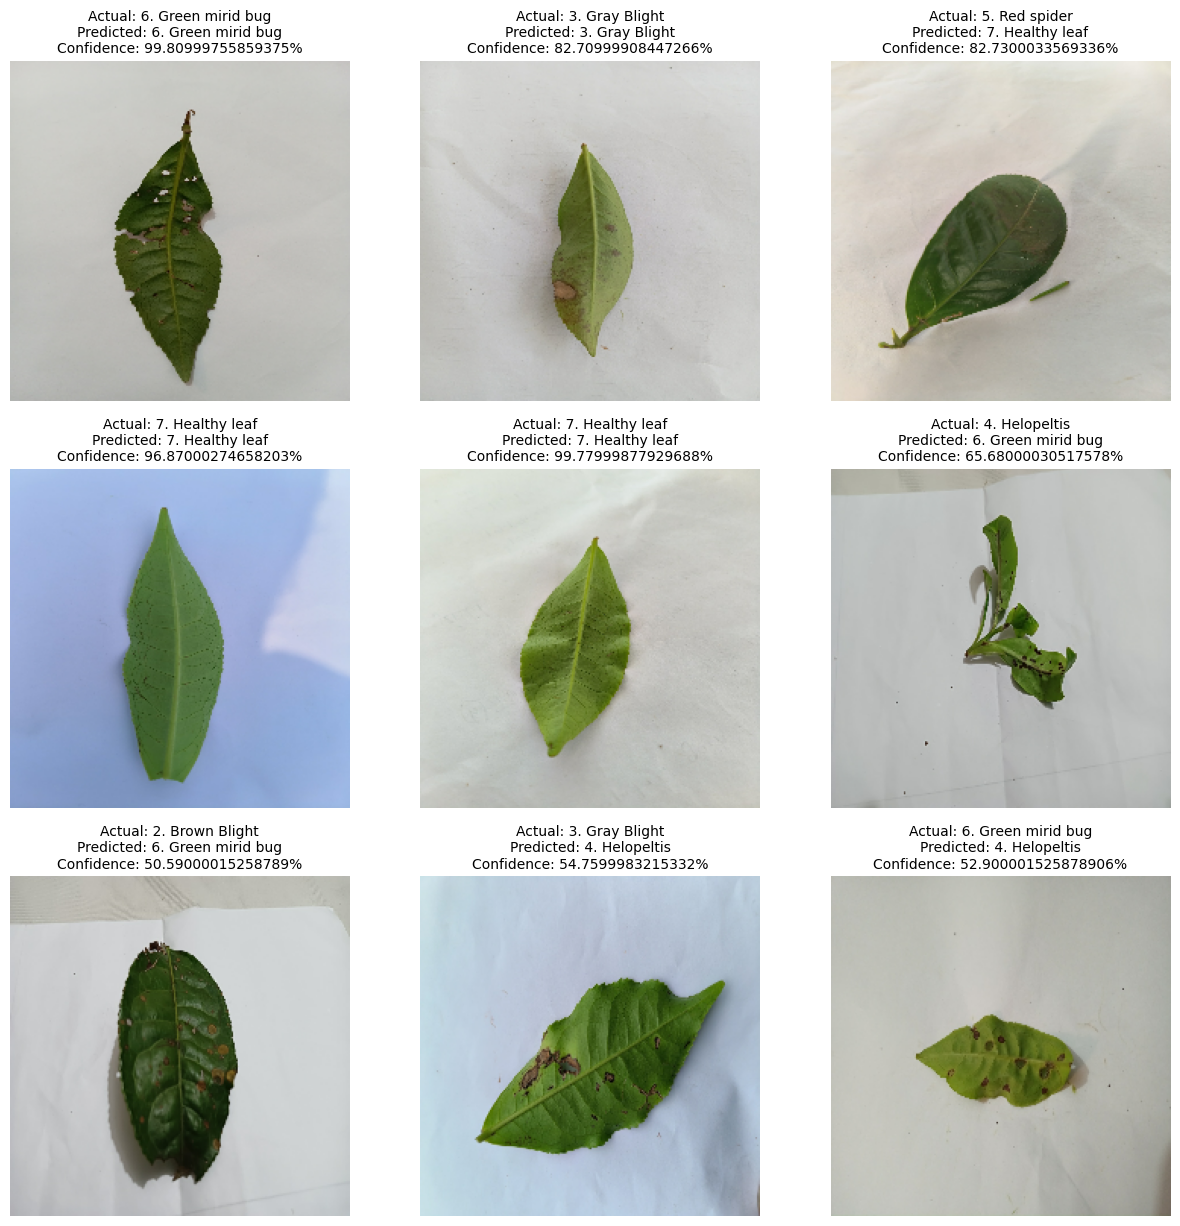

In [51]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", fontsize=10)
        plt.axis("off")

In [52]:
model.save("tea_disease_model.keras")

In [54]:
MODEL_PATH = r"C:\Users\ANISH BHUIN\OneDrive\Desktop\jbooks\notebook\tea_disease_model.keras"


Classification Report:
                        precision    recall  f1-score   support

1. Tea algal leaf spot     0.7059    0.3000    0.4211        40
       2. Brown Blight     0.6061    0.4545    0.5195        44
        3. Gray Blight     0.8824    0.7979    0.8380        94
         4. Helopeltis     0.6267    0.8246    0.7121        57
         5. Red spider     0.7805    0.6275    0.6957        51
    6. Green mirid bug     0.6791    0.8467    0.7537       150
       7. Healthy leaf     0.9811    0.9630    0.9720       108

              accuracy                         0.7665       544
             macro avg     0.7517    0.6877    0.7017       544
          weighted avg     0.7743    0.7665    0.7584       544



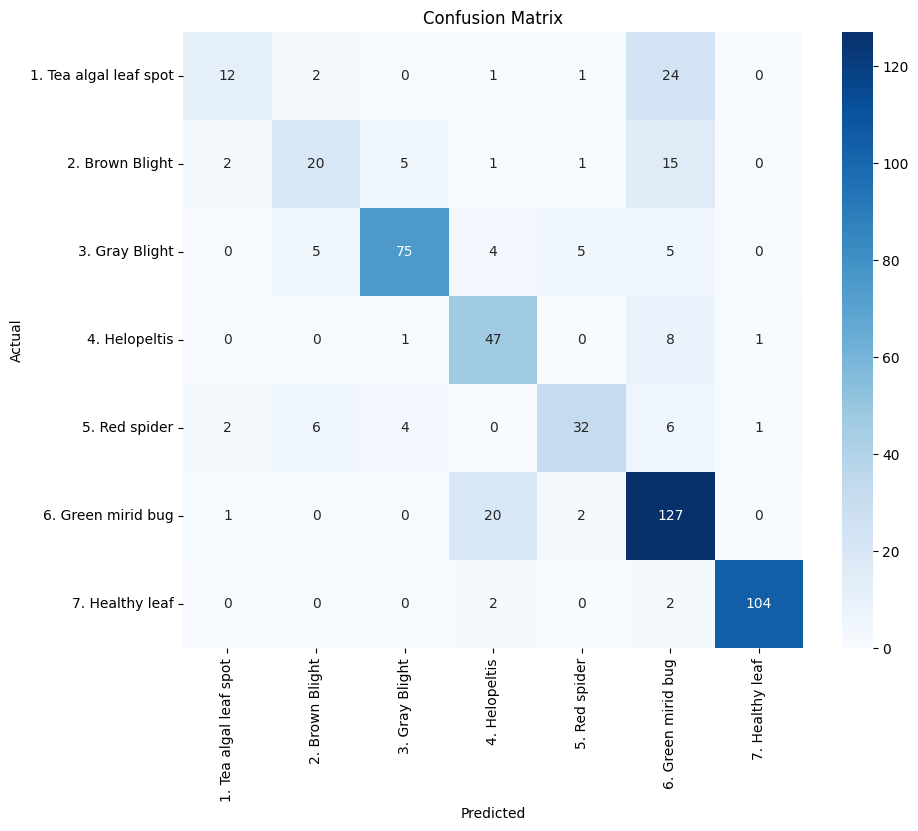

In [55]:
def evaluate_model(test_ds):
    model = tf.keras.models.load_model(MODEL_PATH)
    
    # Get true and predicted labels
    y_true = []
    y_pred = []
    y_prob = []
    
    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
        y_prob.extend(preds)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    return y_true, y_pred, y_prob

y_true, y_pred, y_prob = evaluate_model(test_ds)